In [12]:
import tensorflow as tf
from tensorflow.keras import models,layers
import matplotlib.pyplot as plt

In [13]:
IMAGE_SIZE = 256
BATCH_SIZE = 32
CHANNELS = 3
EPOCHS = 50

In [14]:
datasets = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/drive/MyDrive/Potato_disease_prediction/trainings/PlantVillage",
    shuffle=True,
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE
)


Found 2152 files belonging to 3 classes.


In [15]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [16]:
class_names = datasets.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [17]:
len(datasets)

68

In [18]:
for image_batch, label_batch in datasets.take(1):
    print(image_batch.shape)
    print(image_batch[0])
    print(label_batch.numpy())


(32, 256, 256, 3)
tf.Tensor(
[[[110.  95. 102.]
  [117. 102. 109.]
  [137. 122. 129.]
  ...
  [158. 147. 155.]
  [152. 141. 149.]
  [150. 139. 147.]]

 [[139. 124. 131.]
  [131. 116. 123.]
  [141. 126. 133.]
  ...
  [173. 162. 170.]
  [176. 165. 173.]
  [180. 169. 177.]]

 [[114.  99. 106.]
  [105.  90.  97.]
  [100.  85.  92.]
  ...
  [165. 154. 162.]
  [174. 163. 171.]
  [183. 172. 180.]]

 ...

 [[161. 146. 151.]
  [161. 146. 151.]
  [151. 136. 141.]
  ...
  [120. 107. 114.]
  [158. 145. 152.]
  [111.  98. 105.]]

 [[156. 141. 146.]
  [146. 131. 136.]
  [149. 134. 139.]
  ...
  [153. 140. 147.]
  [205. 192. 199.]
  [139. 126. 133.]]

 [[177. 162. 167.]
  [142. 127. 132.]
  [136. 121. 126.]
  ...
  [153. 140. 147.]
  [153. 140. 147.]
  [206. 193. 200.]]], shape=(256, 256, 3), dtype=float32)
[2 0 1 1 1 0 1 1 1 1 0 0 0 0 0 1 0 1 0 1 1 0 0 1 1 0 0 1 2 0 2 1]


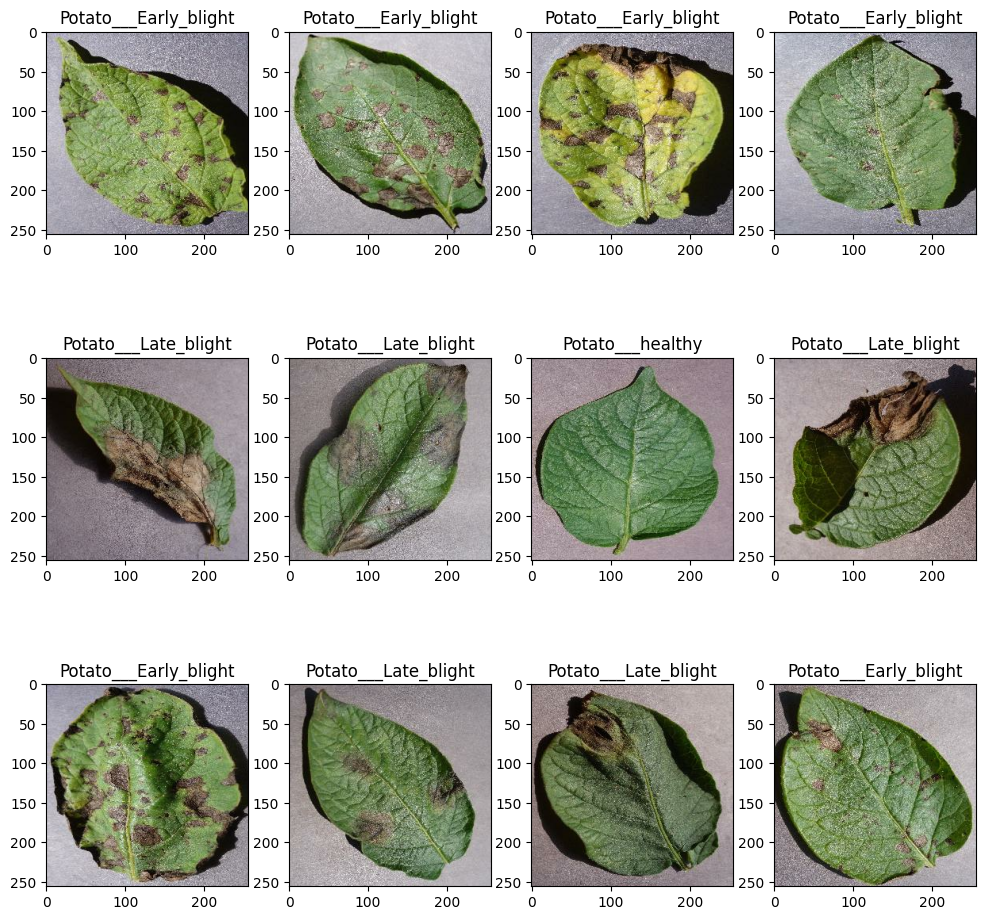

In [19]:
plt.figure(figsize =(12,12))
for image_batch, label_batch in datasets.take(1):
    for i in range(12):
        ax = plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[label_batch[i]])


In [20]:
len(datasets)

68

In [21]:
train_size = 0.8
len(datasets)*train_size

54.400000000000006

In [22]:
#splitting the 80% data in training data
train_ds = datasets.take(54)
len(train_ds)

54

In [23]:
#Rest 20% data is used as a test datasets
test_ds = datasets.skip(54)
len(test_ds)

14

In [24]:
val_size = 0.1
val_ds = test_ds.take(6)
len(val_ds)

6

In [25]:
test_ds = test_ds.skip(6)
len(test_ds)

8

In [26]:
def get_dataset_partition_tf(datasets,train_split=0.8,test_split=0.1,val_split=0.1,shuffle=True,shuffle_size=10000):
    ds_size = len(datasets)

    if shuffle:
        datasets = datasets.shuffle(shuffle_size, seed=12)
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)

    train_ds = datasets.take(train_size)

    val_ds = datasets.skip(train_size).take(val_size)
    test_ds = datasets.skip(train_size).skip(val_size)
    return train_ds , val_ds, test_ds

In [27]:
 train_ds , val_ds,test_ds = get_dataset_partition_tf(datasets)

In [28]:
len(train_ds)



54

In [29]:
len(val_ds)

6

In [30]:
len(test_ds)

8

In [31]:
train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [32]:
#Preprocessing the images
resize_and_rescale = tf.keras.Sequential([
    layers.Resizing(IMAGE_SIZE,IMAGE_SIZE),
    layers.Rescaling(1.0/255)
])

In [33]:
#data augmentation
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2),
])

In [34]:
input_shape= (BATCH_SIZE,IMAGE_SIZE,IMAGE_SIZE,CHANNELS)
n_classes = 3
model = models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32,(3,3),activation="relu",input_shape=input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,kernel_size=(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,kernel_size=(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(n_classes,activation='softmax'),



])
model.build(input_shape=input_shape)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [35]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (32, 256, 256, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_1 (Sequential)       │ (32, 256, 256, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (32, 254, 254, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (32, 127, 127, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (32, 125, 125, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (32, 62, 62, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (32, 60, 60, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (32, 30, 30, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (32, 28, 28, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (32, 14, 14, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (32, 12, 12, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (32, 6, 6, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (32, 4, 4, 64)         │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (32, 2, 2, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (32, 256)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (32, 3)                │           771 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 167,875 (655.76 KB)

 Trainable params: 167,875 (655.76 KB)

 Non-trainable params: 0 (0.00 B)

In [36]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics = ['accuracy']
)

In [37]:
history = model.fit(train_ds,
         epochs=EPOCHS,
         batch_size=BATCH_SIZE,
         verbose=1,
         validation_data=val_ds)

Epoch 1/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 44s 149ms/step - accuracy: 0.4251 - loss: 0.9742 - val_accuracy: 0.6250 - val_loss: 0.7845
Epoch 2/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 54s 171ms/step - accuracy: 0.6852 - loss: 0.7083 - val_accuracy: 0.7440 - val_loss: 0.6109
Epoch 3/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 20s 146ms/step - accuracy: 0.7965 - loss: 0.5014 - val_accuracy: 0.7865 - val_loss: 0.4740
Epoch 4/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 14s 146ms/step - accuracy: 0.8457 - loss: 0.3818 - val_accuracy: 0.7812 - val_loss: 0.4702
Epoch 5/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 13s 146ms/step - accuracy: 0.9049 - loss: 0.2423 - val_accuracy: 0.9427 - val_loss: 0.1417
Epoch 6/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 14s 150ms/step - accuracy: 0.9487 - loss: 0.1415 - val_accuracy: 0.8802 - val_loss: 0.3360
Epoch 7/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 20s 150ms/step - accuracy: 0.9376 - loss: 0.1654 - val_accuracy: 0.8906 - val_loss: 0.2195
Epoch 8/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 13s 153ms/step - accuracy: 0.9624 - loss: 0.1157 - val_accu

In [38]:
scores = model.evaluate(test_ds)

8/8 ━━━━━━━━━━━━━━━━━━━━ 6s 21ms/step - accuracy: 0.9600 - loss: 0.0497


In [39]:
scores

[0.036665402352809906, 0.96875]

In [40]:
history

In [41]:
history.history.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

In [42]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history["loss"]
val_loss = history.history["val_loss"]

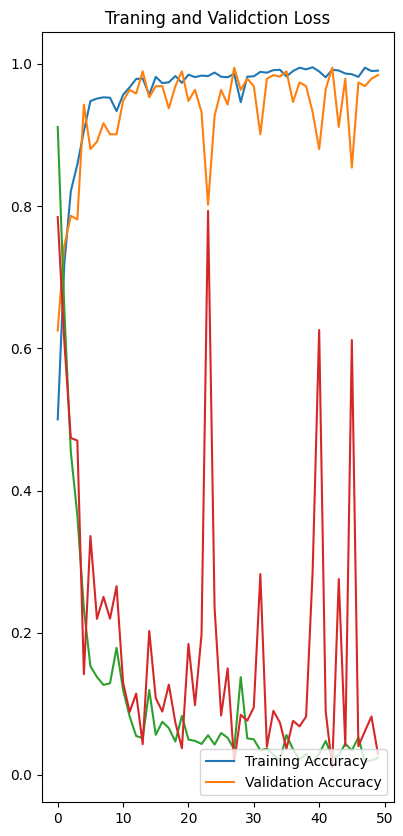

In [43]:
plt.figure(figsize = (10,10))
plt.subplot(1,2,1)
plt.plot(range(EPOCHS),acc,label='Training Accuracy')
plt.plot(range(EPOCHS),val_acc,label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title("Traning and Validation Accuracy")

plt.subplot(1,2,1)
plt.plot(range(EPOCHS),loss,label='Training Loss')
plt.plot(range(EPOCHS),val_loss,label='Validation Loss')
plt.title("Traning and Validction Loss")

plt.show()

First image to predict
actual prediction: Potato___Late_blight
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
predicted label: Potato___Late_blight


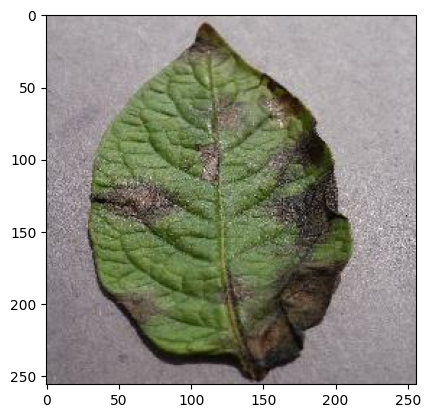

In [46]:
import numpy as np
for images_batch,labels_batch in test_ds.take(1):

    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    print("First image to predict")
    plt.imshow(first_image)
    print("actual prediction:",class_names[first_label])

    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

In [47]:
def predict (model,img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array,0) #create a batch

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 *(np.max(predictions[0])),2)
    return predicted_class,confidence

In [50]:
plt.figure(figsize=(15,15))
for images,labels in test_ds.take(1):
    for i in range(12):
        ax = plt.subplot(3,4,i+1)
        plt.imshow(images[i].numpy().astype("uint8"))

        predicted_class , confidence = predict(model,images[i].numpy())
        actual_class = class_names[labels[i]]
        plt.title(f"Actual class :{actual_class},\n Predicted class:{predicted_class},\n Confidence:{confidence}%")
        plt.axis('off')

Output hidden; open in https://colab.research.google.com to view.

In [54]:
import os
model_version = max([int(i) for i in os.listdir("/content/drive/MyDrive/Potato_disease_prediction/models")+ [0]])+1
model.save(f"/content/drive/MyDrive/Potato_disease_prediction/models{model_version}.keras")
